# Pipeline in Jupyter Notebook

In [40]:
import os
import time

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from transformers import BertTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from src.data_preprocessing import (
    load_data,
    preprocess_data,
    preprocess_blog_data,
    save_processed_data,
)
from src.dataset import SupervisedTextDataset, SupervisedContrastiveTextDataset
from src.contrastive_learning import supervised_contrastive_pretrain
from src.evaluation import evaluate_classifier
from src.model import BertContrastiveModel
from src.supervised_fine_tune import fine_tune_supervised

In [41]:
# Start the timer
start_time = time.time()

In [42]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


### Preprocess the data

In [43]:
# Load and preprocess data
raw_data_path = "data/raw/gender-classification.csv"
processed_data_path = "data/processed"
processed_data_filename = "processed_data.csv"
text_column = "text"
label_column = "gender"

In [44]:
# Load and preprocess external data (blogs data)
external_data_path = "data/raw/blogtext.csv"
processed_external_data_filename = "processed_blog_data.csv"
external_text_column = "text"
external_label_column = "gender"

In [45]:
# # Load raw data (csv file)
# raw_data = load_data(raw_data_path)

# # Preprocess data
# preprocessed_data = preprocess_data(raw_data, text_column, label_column)

# # Save preprocessed data to a csv file
# save_processed_data(preprocessed_data, processed_data_path, processed_data_filename)

In [46]:
# Load blogtext data
# raw_external_data = load_data(external_data_path)

In [47]:
# Preprocess blogtext data
# preprocessed_external_data = preprocess_blog_data(
#     raw_external_data, external_text_column, external_label_column
# )

# # Save preprocessed blogtext data to a csv file
# save_processed_data(
#     preprocessed_external_data, processed_data_path, processed_external_data_filename
# )

In [48]:
# Load preprocessed data
data_df = load_data(f"{processed_data_path}/{processed_data_filename}")

Data loaded successfully from: data/processed/processed_data.csv


In [49]:
data_df.head()

,text,gender
0,long time see like always rewriting scratch co...,0
1,guest demo eric iversons itty bitty search feb...,0
2,moved cheese world developing areas create dif...,0
3,yesterday attended biweekly meeting informal u...,0
4,liam nothing like natalie natalie never went d...,1


In [50]:
data_df.info()
data_df.describe()
data_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3226 entries, 0 to 3225
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3226 non-null   object
 1   gender  3226 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 50.5+ KB


text      0
gender    0
dtype: int64

In [51]:
# Load processed blogtext data
blog_data_df = load_data(
    f"{processed_data_path}/{processed_external_data_filename}"
)

Data loaded successfully from: data/processed/processed_blog_data.csv


In [52]:
blog_data_df.head()

,text,gender
0,info found 100 pages 45 mb pdf files wait unti...,0
1,team members drewes van der laag urllink mail ...,0
2,het kader van kernfusie op aarde maak je eigen...,0
3,testing testing,0
4,thanks yahoos toolbar capture urls popupswhich...,0


In [53]:
blog_data_df.info()
blog_data_df.describe()
blog_data_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611652 entries, 0 to 611651
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    611184 non-null  object
 1   gender  611652 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.3+ MB


text      468
gender      0
dtype: int64

In [54]:
blog_data_df.dropna(subset=[external_text_column], inplace=True)
blog_data_df.isna().sum()

text      0
gender    0
dtype: int64

In [55]:
print(len(blog_data_df))

611184


### Data Splitting

In [56]:
# Texts will be used for contrastive learning
texts = data_df["text"].tolist()
labels = data_df["gender"].tolist()

print("Data loaded and preprocessed.")
print(f"Number of samples: {len(texts)}")
print(f"Number of labels: {len(labels)}")

Data loaded and preprocessed.
Number of samples: 3226
Number of labels: 3226


### Contrastive Learning
Pre-train the model to learn the representation of the data in order to distinguish between similar and dissimilar data points.

In [57]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [58]:
# Extract texts and labels for supervised contrastive learning pre-training
texts_ctr = blog_data_df["text"].tolist()
labels_ctr = blog_data_df["gender"].tolist()

print("Blog data (external) loaded and preprocessed for contrastive learning.")
print(f"Number of samples for contrastive learning: {len(texts_ctr)}")
print(f"Number of labels for contrastive learning: {len(labels_ctr)}")

Blog data (external) loaded and preprocessed for contrastive learning.
Number of samples for contrastive learning: 611184
Number of labels for contrastive learning: 611184


In [59]:
# Test with subset of blog data (10K from 600k+)

texts_ctr_subset, _, labels_ctr_subset, _ = train_test_split(
    texts_ctr, labels_ctr, train_size=10000, stratify=labels_ctr, random_state=42
)
# texts_ctr_subset, _, labels_ctr_subset, _ = train_test_split(
#     texts_ctr, labels_ctr, train_size=6000, stratify=labels_ctr, random_state=42
# )
print(f"Number of samples for contrastive learning subset: {len(texts_ctr_subset)}")

Number of samples for contrastive learning subset: 10000


<Axes: ylabel='count'>

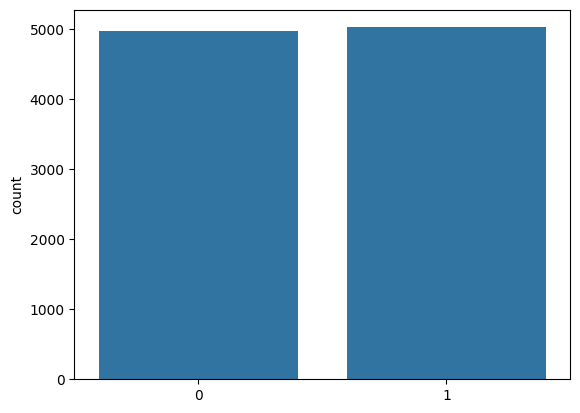

In [60]:
# Check the distribution of labels in the subset
sns.countplot(x=labels_ctr_subset)

In [61]:
# ### PCA on external blog data
# import joblib
# import numpy as np
# from sklearn.decomposition import PCA


# # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# model = BertContrastiveModel().to(device)
# model.eval()

# dataset = SupervisedTextDataset(texts=texts_ctr_subset, labels=labels_ctr_subset, tokenizer=tokenizer)
# loader = DataLoader(
#     dataset,
#     batch_size=32,
#     # batch_size=16,
#     shuffle=False,
# )

# all_pooled = []
# with torch.no_grad():
#     for batch in loader:
#         encoded, _ = batch
#         pooled = model.encode(
#             encoded["input_ids"].to(device),
#             encoded["attention_mask"].to(device),
#             encoded["token_type_ids"].to(device),
#         )
#         all_pooled.append(pooled.cpu().numpy())
        
# all_pooled = np.vstack(all_pooled) # shape (N, 768)

# # pca_full = PCA(n_components=768).fit(all_pooled)   # all_pooled: (N,768)
# # cumvar = np.cumsum(pca_full.explained_variance_ratio_)
# # # find smallest K where cumvar[K-1] >= desired_threshold
# # desired = 0.95  # 95% variance
# # K_95 = np.searchsorted(cumvar, desired) + 1
# # print(f"Need {K_95} components to retain {desired*100:.0f}% of variance")

# # Fit PCA
# # pca = PCA(n_components=256)
# pca = PCA(n_components=64)
# pca.fit(all_pooled)
# # Save PCA model
# # joblib.dump(pca, "models/bert_pca_256.joblib")
# joblib.dump(pca, "models/bert_pca_64.joblib")
# print("PCA model saved.")

In [62]:
# Create a custom dataset for contrastive learning on the training set
# This dataset will perform data augmentation on the input text samples
# (1 original + 1 augmented sample per text)


contrastive_dataset = SupervisedContrastiveTextDataset(
    texts_ctr_subset,
    labels_ctr_subset,
    tokenizer,
    max_length=128,
    augment=True,
)

contrastive_loader = DataLoader(contrastive_dataset, batch_size=16, shuffle=True)
# contrastive_loader = DataLoader(contrastive_dataset, batch_size=8, shuffle=True)

# May change to a larger batch size to have more negative samples
# for contrastive learning

print("Contrastive dataset created (with data augmentation).")

Contrastive dataset created (with data augmentation).


In [63]:
# Initialize our model: BERT encoder with projection and classifier heads
# model = BertContrastiveModel(proj_dim=64, num_labels=2, dropout_prob=0.3)
model = BertContrastiveModel(proj_dim=64, num_labels=2, dropout_prob=0.5)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model initialized and moved to device.")

Model initialized and moved to device.


In [64]:
##################################
# CONTRASTIVE PRE-TRAINING PHASE
##################################


# # Initialize the adam optimizer
# optimizer_ctr = optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-4)

# # Run supervised contrastive pre-training
# supervised_contrastive_pretrain(
#     model,
#     contrastive_loader,
#     optimizer_ctr,
#     device,
#     # temperature=0.5,
#     temperature=0.2,
#     num_epochs=5,
#     file_name="bert_supervised_contrastive_pretrained_final_pca_2.pth",
# )

print("Supervised Contrastive pre-training complete. Model saved.")

Supervised Contrastive pre-training complete. Model saved.


### Supervised Fine-tuning
Fine-tune our pre-trained model on a classification task using labeled data.

In [65]:
# Create custom datasets for supervised training
# This will not perform data augmentation on the input text samples

supervised_dataset = SupervisedTextDataset(
    texts, labels, tokenizer, max_length=128, augment=False
)

# Split data: 20% as test; from remaining, 20% as validation
total_len = len(supervised_dataset)
test_len = int(0.2 * total_len)
remaining = total_len - test_len
val_len = int(0.2 * remaining)
train_len = remaining - val_len

train_dataset, val_dataset, test_dataset = random_split(
    supervised_dataset, [train_len, val_len, test_len]
)

# batch_size = 8
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data loaded and split into train, validation, and test sets.")

Data loaded and split into train, validation, and test sets.


***NOTE: This is important to cool down the machine a bit before running the supervised fine-tuning. After the contrastive learning, the machine will need to "take some rest" before running the next heavy task.***

*Just like a human brain, the machine needs to "rest" before running the next heavy task.*

In [66]:
# Let computer cool down in 5 minutes with no activity
# print("Cooling down for 2 minutes...")
# time.sleep(120)
# print("Cool down complete. Resuming...")

In [67]:
# Load pre-trained contrastive model weights
pre_trained_path = os.path.join("models", "bert_supervised_contrastive_pretrained_final_pca_2.pth")

# Check if the pre-trained model weights exist
if not os.path.exists(pre_trained_path):
    raise FileNotFoundError(
        f"Pre-trained model weights not found at {pre_trained_path}. Please run supervised contrastive pre-training first."
    )

model.load_state_dict(torch.load(pre_trained_path))

print("Loaded pre-trained supervised contrastive model weights.")

Loaded pre-trained supervised contrastive model weights.


In [68]:
################################
# SUPERVISED FINE-TUNING PHASE
################################


# Initialize the adam optimizer
# optimizer_ft = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
optimizer_ft = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Perform model fine-tuning on labeled dataset
history, best_val_acc = fine_tune_supervised(
    model,
    train_loader,
    val_loader,
    optimizer_ft,
    device,
    num_epochs=10,
    patience=3,
    file_name="best_bert_supervised_final_pca_2.pth",
)

print(f"Best validation accuracy: {best_val_acc:.4f}")
print("Supervised fine-tuning complete. Model saved.")

Epoch [1/10] - Train Loss: 0.6613, Val Loss: 0.5938, Val Acc: 0.6880
Best validation accuracy updated: 0.6880
Best supervised model updated and saved at models/best_bert_supervised_final_pca_2.pth
Epoch [2/10] - Train Loss: 0.5815, Val Loss: 0.5811, Val Acc: 0.6880
Epoch [3/10] - Train Loss: 0.4633, Val Loss: 0.5777, Val Acc: 0.7016
Best validation accuracy updated: 0.7016
Best supervised model updated and saved at models/best_bert_supervised_final_pca_2.pth
Epoch [4/10] - Train Loss: 0.2652, Val Loss: 0.6829, Val Acc: 0.7209
Best validation accuracy updated: 0.7209
Best supervised model updated and saved at models/best_bert_supervised_final_pca_2.pth
Epoch [5/10] - Train Loss: 0.1053, Val Loss: 1.0487, Val Acc: 0.6802
Validation loss exceeds 1.0487090077453343. Early stopping triggered.
Supervised fine-tuning complete.
Best validation accuracy: 0.7209
Supervised fine-tuning complete. Model saved.


In [69]:
###################################
# Plot supervised learning curves
###################################
def plot_learning_curves(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train Loss", "Val Loss"], loc="upper right")
    plt.title("Model Training/Validation Loss")

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Learning Curve: Validation Accuracy")

    plt.tight_layout()
    plt.show()

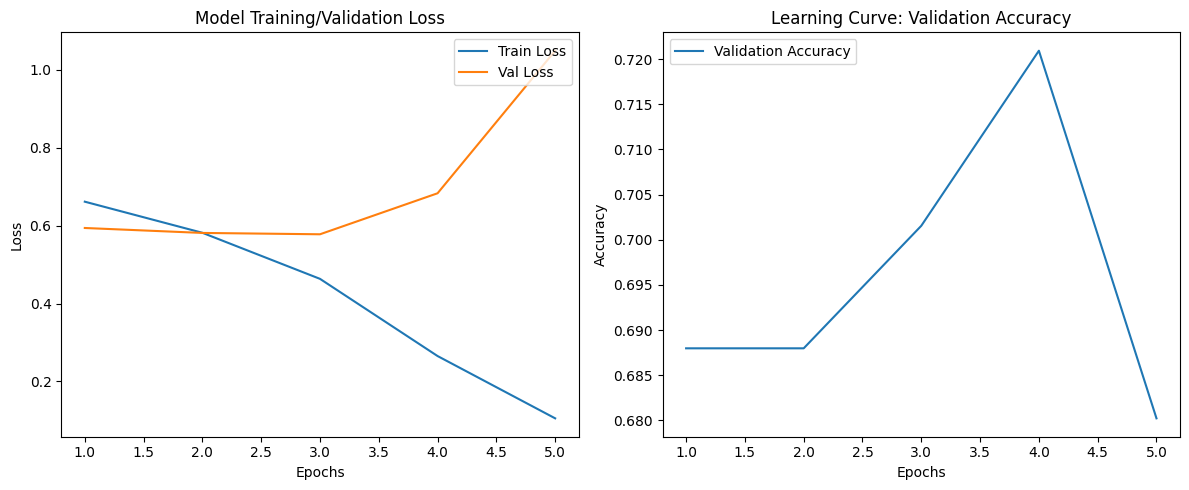

In [70]:
plot_learning_curves(history)

***NOTE: This is important to cool down the machine again a bit before running the evaluation. After the contrastive learning and supervised fine-tuning, the machine is probably very "tired" and will need to "take some rest" before running the evaluation.***

In [71]:
# Let computer cool down in 5 minutes with no activity
# print("Cooling down for 5 minutes...")
print("Cooling down for 1 minutes...")
# time.sleep(300)
time.sleep(60)
print("Cool down complete. Resuming...")

Cooling down for 1 minutes...
Cool down complete. Resuming...


### Evaluation
Evaluate the model on a train/validation/test set to measure its performance.

In [72]:
# Load the supervised model weights
supervised_model_path = os.path.join("models", "best_bert_supervised_final_pca_2.pth")
# Check if the supervised model weights exist
if not os.path.exists(supervised_model_path):
    raise FileNotFoundError(
        f"Supervised model weights not found at {supervised_model_path}. Please run supervised fine-tuning first."
    )

# model.load_state_dict(torch.load(supervised_model_path))

# Load up the model (entire model, not just weights)
model = torch.load(supervised_model_path, weights_only=False)

print("Loaded best supervised model weights.")

Loaded best supervised model weights.


In [73]:
# current_state = model.state_dict()
# print("Current state of the model:")
# for key, value in current_state.items():
#     print(f"{key}: {value.size()}")

In [74]:
def print_eval_results(results):
    """Prints the evaluation results.

    Args:
        results (dict): A dictionary containing evaluation metrics including
            loss, accuracy, f1 score, confusion matrix, and classification report.
    """
    print(f"Loss: {results['loss']:.4f}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"F1 Score: {results['f1']:.4f}")
    print("Confusion Matrix:")
    print(results["confusion_matrix"])
    print("Classification Report:")
    print(results["report"])
    print("=" * 30)

Evaluating on train set:
Loss: 0.0966
Accuracy: 0.9758
F1 Score: 0.9758
Classification Report:
              precision    recall  f1-score   support

           M       0.97      0.99      0.98      1051
           F       0.99      0.96      0.98      1014

    accuracy                           0.98      2065
   macro avg       0.98      0.98      0.98      2065
weighted avg       0.98      0.98      0.98      2065



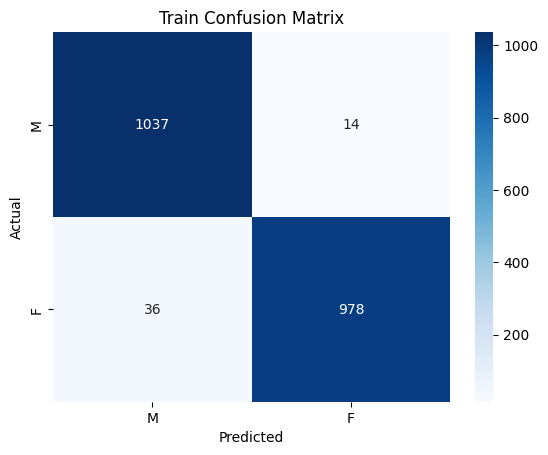

In [75]:
########################################
# Evaluate the model on the all 3 sets
#######################################

print("Evaluating on train set:")
train_eval = evaluate_classifier(model, train_loader, device)
print(f"Loss: {train_eval['loss']:.4f}")
print(f"Accuracy: {train_eval['accuracy']:.4f}")
print(f"F1 Score: {train_eval['f1']:.4f}")
print("Classification Report:")
print(train_eval["report"])

sns.heatmap(
    train_eval["confusion_matrix"],
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["M", "F"],
    yticklabels=["M", "F"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Train Confusion Matrix")
plt.show()

print("=" * 30)

Evaluating on validation set:


Loss: 0.6829
Accuracy: 0.7209
F1 Score: 0.7200
Classification Report:
              precision    recall  f1-score   support

           M       0.72      0.77      0.74       271
           F       0.72      0.67      0.69       245

    accuracy                           0.72       516
   macro avg       0.72      0.72      0.72       516
weighted avg       0.72      0.72      0.72       516



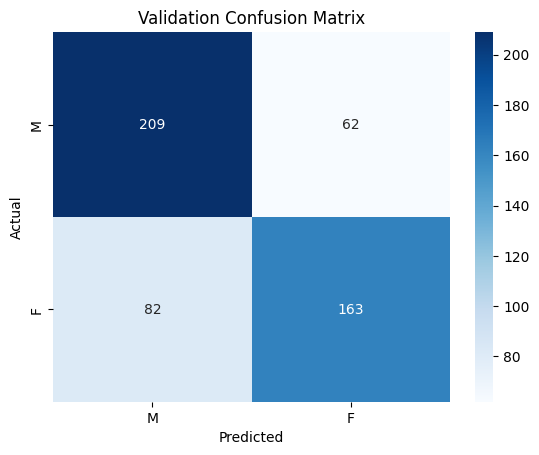

In [76]:
print("Evaluating on validation set:")
val_eval = evaluate_classifier(model, val_loader, device)
print(f"Loss: {val_eval['loss']:.4f}")
print(f"Accuracy: {val_eval['accuracy']:.4f}")
print(f"F1 Score: {val_eval['f1']:.4f}")
print("Classification Report:")
print(val_eval["report"])

sns.heatmap(
    val_eval["confusion_matrix"],
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["M", "F"],
    yticklabels=["M", "F"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Validation Confusion Matrix")
plt.show()

Evaluating on test set:
Loss: 0.7344
Accuracy: 0.7070
F1 Score: 0.7067
Classification Report:
              precision    recall  f1-score   support

           M       0.73      0.74      0.74       356
           F       0.68      0.66      0.67       289

    accuracy                           0.71       645
   macro avg       0.70      0.70      0.70       645
weighted avg       0.71      0.71      0.71       645



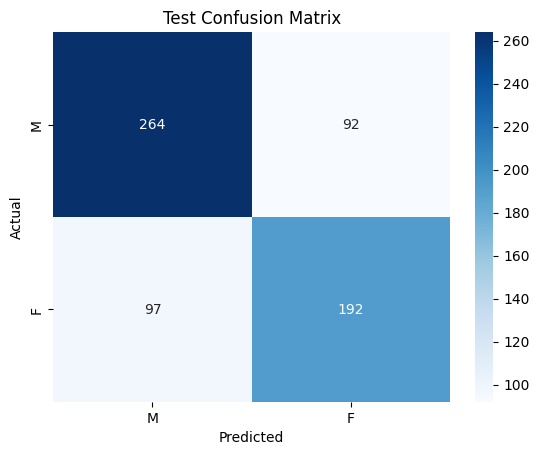

Evaluation complete.


In [77]:
print("Evaluating on test set:")
test_eval = evaluate_classifier(model, test_loader, device)
print(f"Loss: {test_eval['loss']:.4f}")
print(f"Accuracy: {test_eval['accuracy']:.4f}")
print(f"F1 Score: {test_eval['f1']:.4f}")
print("Classification Report:")
print(test_eval["report"])

sns.heatmap(
    test_eval["confusion_matrix"],
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["M", "F"],
    yticklabels=["M", "F"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Confusion Matrix")
plt.show()

print("=" * 30)
print("Evaluation complete.")

In [78]:
# End the timer
end_time = time.time()
execution_time = end_time - start_time
execution_time_in_minutes = execution_time / 60
print(f"Pipeline total execution time: {execution_time_in_minutes:.2f} minutes")
# print(f"Pipeline total execution time: {execution_time:.2f} seconds")
print("All tasks completed successfully.")

Pipeline total execution time: 9.05 minutes
All tasks completed successfully.
